# Case Study: Image Segmentation of Indian Traffic

## 1. Importing Libraries and DataSet

In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import urllib

import tensorflow as tf
import keras
import random as rn
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import get_source_inputs

os.environ["SM_FRAMEWORK"] = 'tf.keras'

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Reshape, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["SM_FRAMEWORK"] = 'tf.keras'
tf.keras.backend.set_image_data_format('channels_last')

In [5]:
# Unzip data
!unzip /content/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

## 2. Preprocessing

### 2.1 Get all the file name and corresponding json files

In [6]:
def return_file_names_df(root_dir):
    image_dir_path = os.path.join(root_dir,'images')
    mask_dir_path = os.path.join(root_dir,'mask')

    pattern = r'_'
    image_dict = dict()

    for i in os.listdir(image_dir_path):
      for image in os.listdir(os.path.join(image_dir_path,i)):
        img = os.path.splitext(image)
        img_name = re.split(pattern, img[0])
        image_dict.update({os.path.join(i,img_name[0]):os.path.join(image_dir_path,i,image)})

    mask_dict = dict()
    for i in os.listdir(mask_dir_path):
      for pos_json in os.listdir(os.path.join(mask_dir_path,i)):
        mask = os.path.splitext(pos_json)
        mask_name = re.split(pattern, mask[0])
        mask_dict.update({os.path.join(i,mask_name[0]):os.path.join(mask_dir_path,i,pos_json)})

    path_list = []
    for key,value in image_dict.items():
      path_list.append([image_dict[key],mask_dict[key]])

    img_list = [x[0] for x in path_list]
    mask_list = [x[1] for x in path_list]

    d = {'image': img_list, 'json': mask_list}
    data_df = pd.DataFrame(data=d)

    return data_df

In [7]:
root_dir = 'data/'
data_df = return_file_names_df(root_dir)
data_df.head()

image  \
0  data/images/237/frame63930_leftImg8bit.jpg   
1  data/images/237/frame12976_leftImg8bit.jpg   
2  data/images/237/frame12771_leftImg8bit.jpg   
3   data/images/237/frame7134_leftImg8bit.jpg   
4   data/images/237/frame0724_leftImg8bit.jpg   

                                            json  
0  data/mask/237/frame63930_gtFine_polygons.json  
1  data/mask/237/frame12976_gtFine_polygons.json  
2  data/mask/237/frame12771_gtFine_polygons.json  
3   data/mask/237/frame7134_gtFine_polygons.json  
4   data/mask/237/frame0724_gtFine_polygons.json

In [8]:
data_df.shape

(4008, 2)

### 2.2 Reading sample Json file

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### 2.2.1Compute the unique labels

In [9]:
def return_unique_labels(data_df):

    json_list = data_df['json'].tolist()

    labels = []
    for each in json_list:
      f = open(each)
      data = json.load(f)
      obj = data['objects']
      for each in obj:
        labels.append(each['label'])

    unique, counts = np.unique(labels, return_counts=True)
    unique_labels = dict(zip(unique, counts))

    return unique_labels

In [10]:
unique_labels = return_unique_labels(data_df)

In [11]:
len(unique_labels)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [12]:
# we are considering 21 different set of objects just to make different objects look differently in the segmentation map

label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

#### 2.2.2 Extracting the polygons from the json files

In [13]:
def get_poly(file):

    f = open(file)
    data = json.load(f)

    h = data['imgHeight']
    w = data['imgWidth']
    obj = data['objects']

    label = []
    vertexlist = []
    for each in obj:
      label.append(each['label'])
      vertexlist.append(each['polygon'])

    new_vertex_list = []
    for each in vertexlist:
      temp = [tuple(x) for x in each]
      new_vertex_list.append(temp)

    return w, h, label, new_vertex_list

#### 2.2.3 Creating Image segmentations by drawing set of polygons

In [14]:
def compute_masks(data_df):

    json_file = data_df['json'].tolist()
    mask_list = []
    for each in json_file:
      pattern = r'/'
      title, ext = os.path.splitext(each)
      title = re.sub(r'mask', 'output', title)
      dir_list = re.split(pattern, title)
      directory = '/'.join(dir_list[:-1])
      new_file = os.path.join(directory, dir_list[-1] +'.png')
      mask_list.append(new_file)

      w, h, label, vertex_list = get_poly(each)
      img = Image.new("RGB", (w, h))
      img1 = ImageDraw.Draw(img)
      for i in range(len(vertex_list)):
        if len(vertex_list[i])!= 0 and len(vertex_list[i]) >1:
          img1.polygon(vertex_list[i], fill = label_clr[label[i]])

      img=np.array(img)
      im = Image.fromarray(img[:,:,0])

      if not os.path.exists(directory):
        os.makedirs(directory)
        im.save(new_file)
      else:
        im.save(new_file)

    data_df['mask'] = mask_list

    return data_df

In [15]:
data_df = compute_masks(data_df)
data_df.head()

image  \
0  data/images/237/frame63930_leftImg8bit.jpg   
1  data/images/237/frame12976_leftImg8bit.jpg   
2  data/images/237/frame12771_leftImg8bit.jpg   
3   data/images/237/frame7134_leftImg8bit.jpg   
4   data/images/237/frame0724_leftImg8bit.jpg   

                                            json  \
0  data/mask/237/frame63930_gtFine_polygons.json   
1  data/mask/237/frame12976_gtFine_polygons.json   
2  data/mask/237/frame12771_gtFine_polygons.json   
3   data/mask/237/frame7134_gtFine_polygons.json   
4   data/mask/237/frame0724_gtFine_polygons.json   

                                             mask  
0  data/output/237/frame63930_gtFine_polygons.png  
1  data/output/237/frame12976_gtFine_polygons.png  
2  data/output/237/frame12771_gtFine_polygons.png  
3   data/output/237/frame7134_gtFine_polygons.png  
4   data/output/237/frame0724_gtFine_polygons.png

In [16]:
data_df.shape

(4008, 3)

In [17]:
# Saving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

### 2.3 Creating the Batch Dataset for the model.

In [18]:
# Split dataset into train and test

X_train, X_test = train_test_split(data_df, test_size=0.15, random_state=42)

print(X_train.shape, X_test.shape)

(3406, 3) (602, 3)


In [19]:
# Applying few augumentation techniques

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug5 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [20]:
class Dataset:
    class_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

    def __init__(self, df):

        # the paths of images
        self.images_fps   = df['image'].tolist()
        # the paths of segmentation images
        self.masks_fps    = df['mask'].tolist()
        # giving labels for each class
        self.class_values = self.class_values


    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_AREA)

        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.5:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = image_mask
        else:
            image = aug5.augment_image(image)
            image_mask = aug5.augment_image(image_mask)

        return image, image_mask

    def __len__(self):
        return len(self.images_fps)

In [21]:
class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [22]:
train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_test)

In [23]:
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

In [24]:
print(train_dataloader[0][0].shape)
print(test_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print(test_dataloader[0][1].shape)

(8, 512, 512, 3)
(8, 512, 512, 3)
(8, 512, 512, 21)
(8, 512, 512, 21)


## 3. Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* Library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* We are using iou as loss function

</pre>

### 3.1: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* Ploting 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
# Transfer lerning Unet model
model = Unet('resnet34', encoder_weights='imagenet', encoder_freeze=True,
             classes=21, activation='softmax', input_shape=(512,512,3))

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 512, 512, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, 518, 518, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [ ]:
optim = keras.optimizers.Adam(0.01)

focal_loss = sm.losses.cce_dice_loss

In [ ]:
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('best_weight_unet.h5', save_weights_only=True,
                                             save_best_only=True, mode='min', monitor='val_iou_score'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.01,patience=2)
]

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,
                    validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/20
425/425 [==============================] - 764s 2s/step - loss: 0.7581 - iou_score: 0.2331 - val_loss: 0.8611 - val_iou_score: 0.1781 - lr: 0.0100
Epoch 2/20
425/425 [==============================] - 721s 2s/step - loss: 0.6533 - iou_score: 0.3144 - val_loss: 0.7138 - val_iou_score: 0.2789 - lr: 0.0100
Epoch 3/20
425/425 [==============================] - 718s 2s/step - loss: 0.6109 - iou_score: 0.3500 - val_loss: 0.7374 - val_iou_score: 0.2629 - lr: 0.0100
Epoch 4/20
425/425 [==============================] - 712s 2s/step - loss: 0.5858 - iou_score: 0.3710 - val_loss: 0.6516 - val_iou_score: 0.3195 - lr: 0.0100
Epoch 5/20
425/425 [==============================] - 718s 2s/step - loss: 0.5688 - iou_score: 0.3870 - val_loss: 0.6029 - val_iou_score: 0.3591 - lr: 0.0100
Epoch 6/20
425/425 [==============================] - 706s 2s/step - loss: 0.5578 - iou_score: 0.3954 - val_loss: 0.7193 - val_iou_score: 0.2834 - lr: 0.0100
Epoch 7/20
425/425 [==============================] 

<pre>
Observation:
<li>IOU score for Train data and Validation Data after 20th epoch are 0.6146 and 0.5707.
</pre>

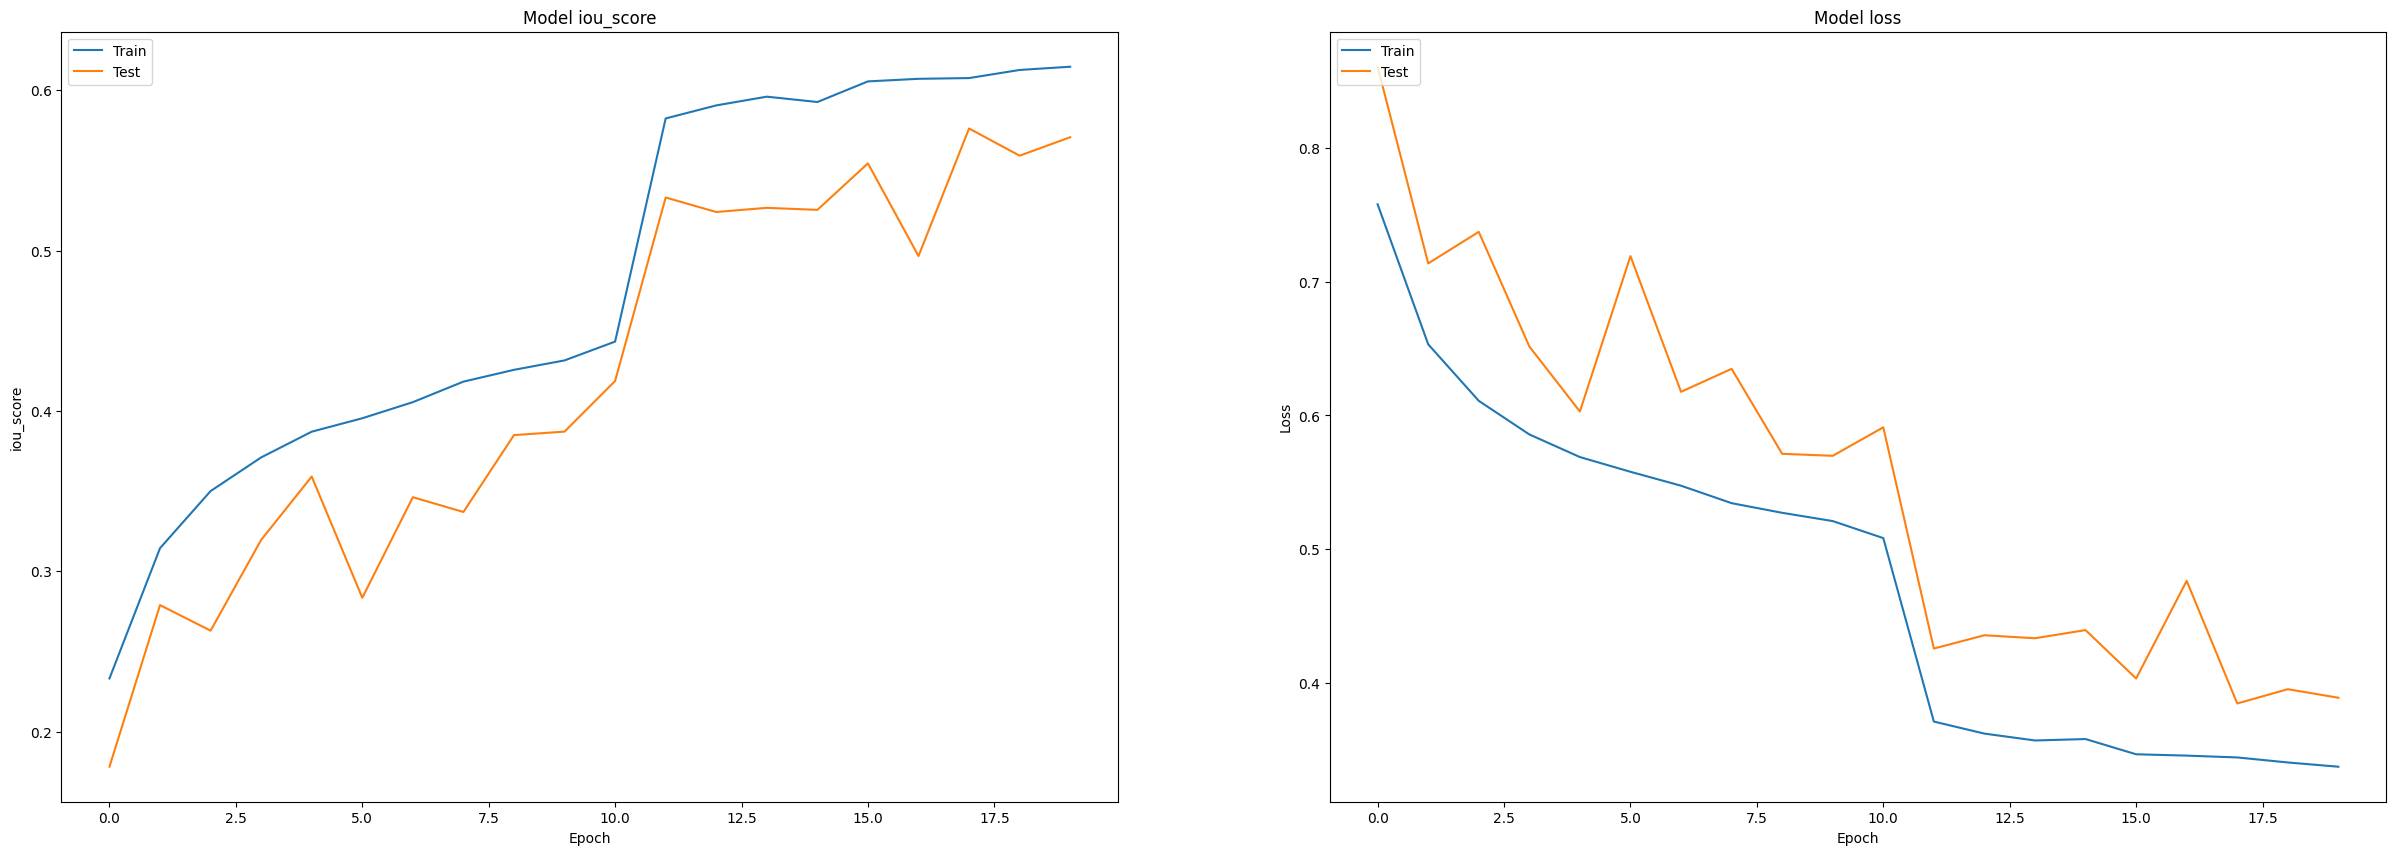

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Loading the best weights to model
model.load_weights("best_weight_unet.h5")

In [ ]:
# Testing the model for 20 test images
test_model = X_test.sample(n = 20)
test_model = test_model.reset_index(drop=True)
test_model.head()

image  \
0  data/images/295/frame20495_leftImg8bit.jpg   
1   data/images/224/frame2947_leftImg8bit.jpg   
2  data/images/288/frame31513_leftImg8bit.jpg   
3  data/images/213/frame30430_leftImg8bit.jpg   
4  data/images/320/frame15404_leftImg8bit.jpg   

                                            json  \
0  data/mask/295/frame20495_gtFine_polygons.json   
1   data/mask/224/frame2947_gtFine_polygons.json   
2  data/mask/288/frame31513_gtFine_polygons.json   
3  data/mask/213/frame30430_gtFine_polygons.json   
4  data/mask/320/frame15404_gtFine_polygons.json   

                                             mask  
0  data/output/295/frame20495_gtFine_polygons.png  
1   data/output/224/frame2947_gtFine_polygons.png  
2  data/output/288/frame31513_gtFine_polygons.png  
3  data/output/213/frame30430_gtFine_polygons.png  
4  data/output/320/frame15404_gtFine_polygons.png

1/1 [==============================] - 0s 21ms/step


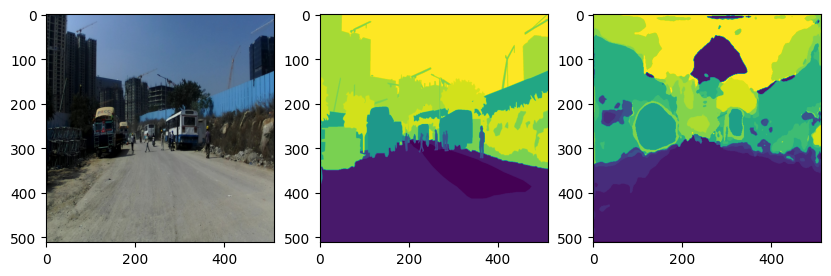

1/1 [==============================] - 0s 30ms/step


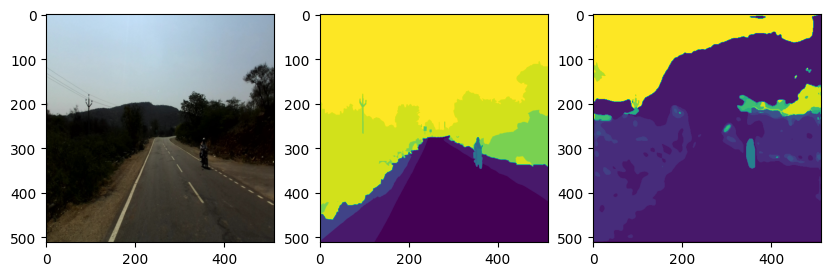

1/1 [==============================] - 0s 25ms/step


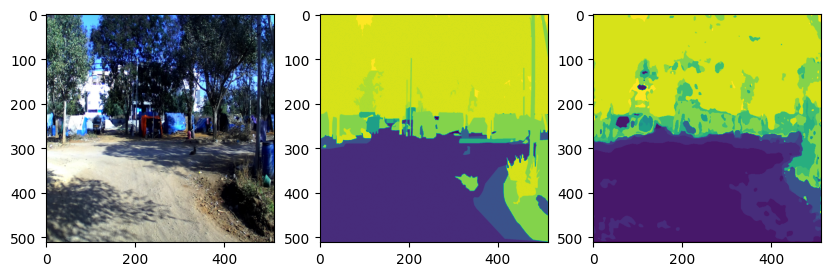

1/1 [==============================] - 0s 33ms/step


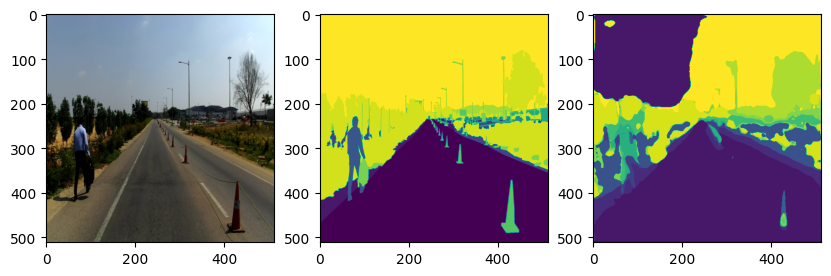

1/1 [==============================] - 0s 31ms/step


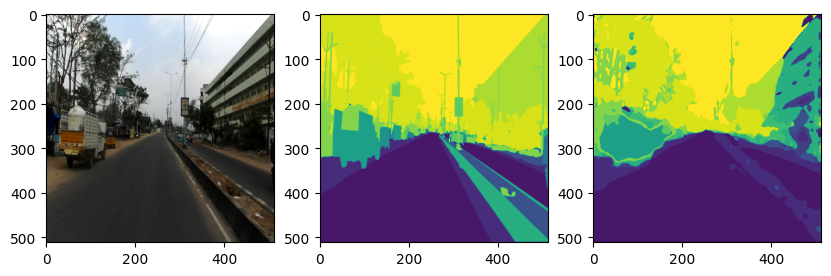

1/1 [==============================] - 0s 34ms/step


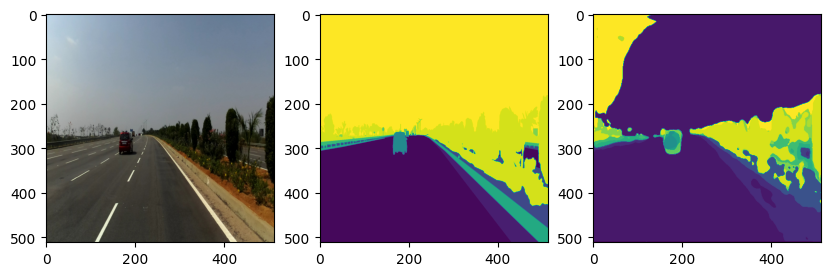

1/1 [==============================] - 0s 22ms/step


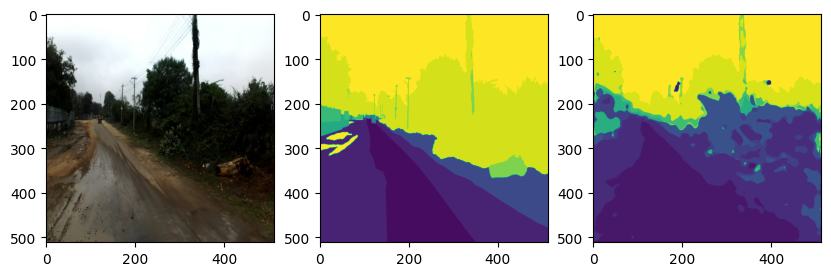

1/1 [==============================] - 0s 22ms/step


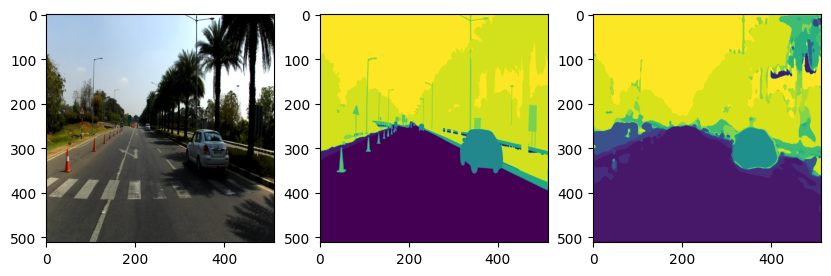

1/1 [==============================] - 0s 22ms/step


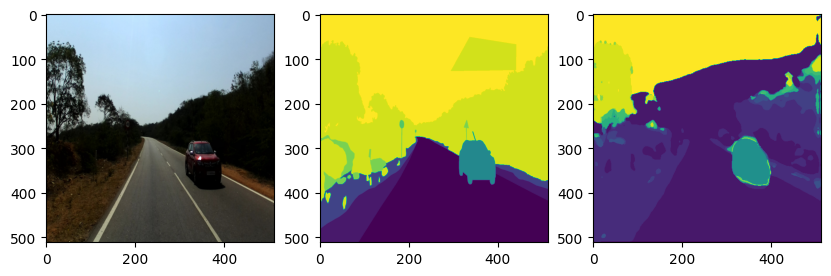

1/1 [==============================] - 0s 32ms/step


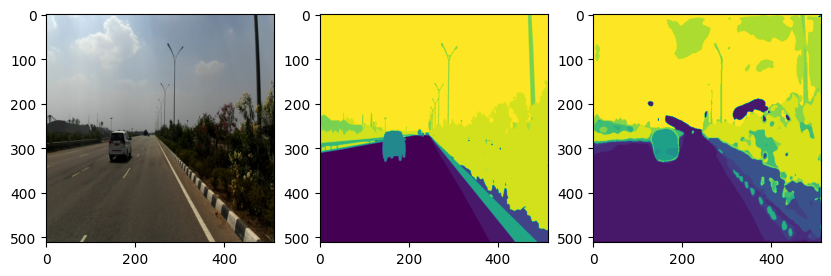

1/1 [==============================] - 0s 22ms/step


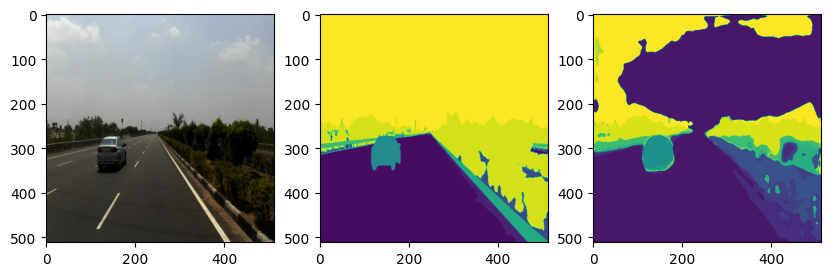

1/1 [==============================] - 0s 22ms/step


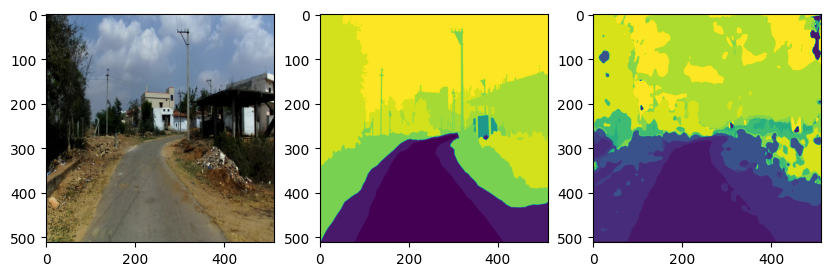

1/1 [==============================] - 0s 23ms/step


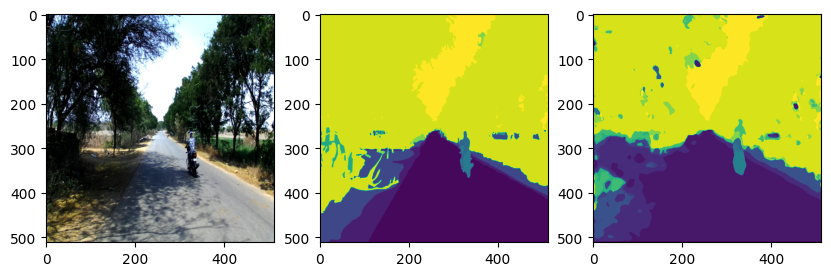

1/1 [==============================] - 0s 22ms/step


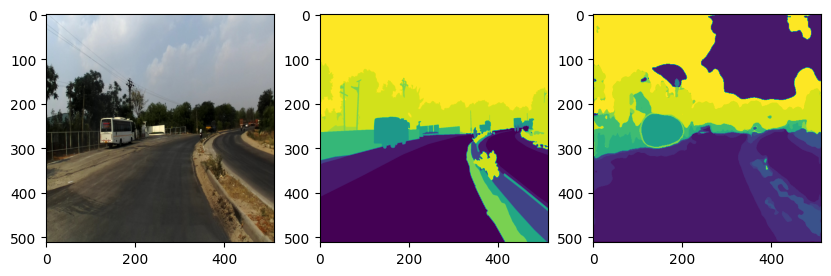

1/1 [==============================] - 0s 21ms/step


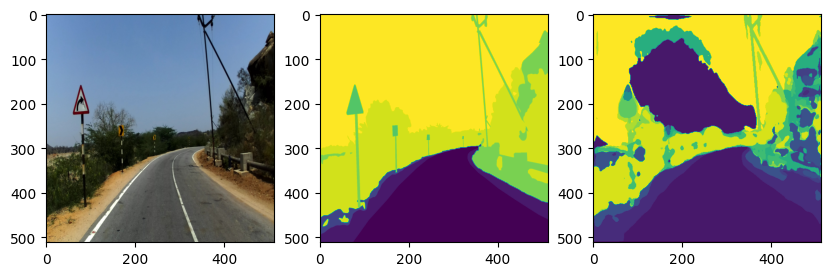

1/1 [==============================] - 0s 23ms/step


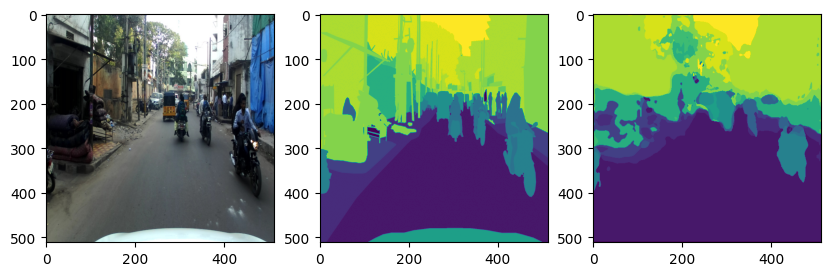

1/1 [==============================] - 0s 22ms/step


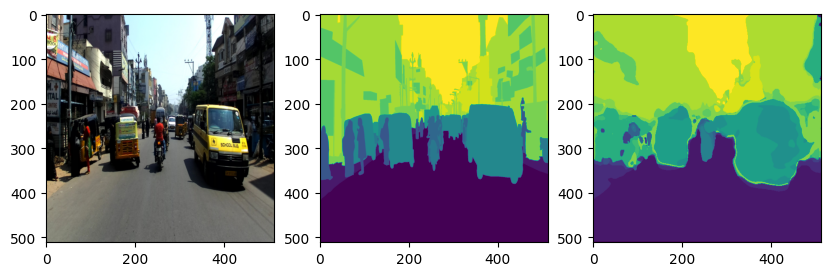

1/1 [==============================] - 0s 21ms/step


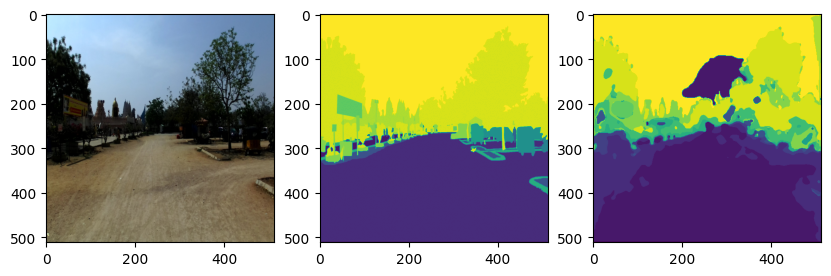

1/1 [==============================] - 0s 23ms/step


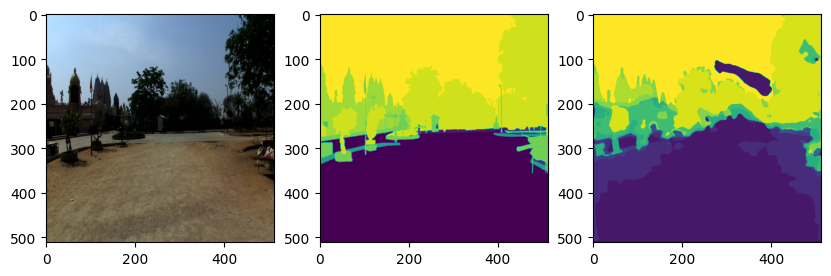

1/1 [==============================] - 0s 22ms/step


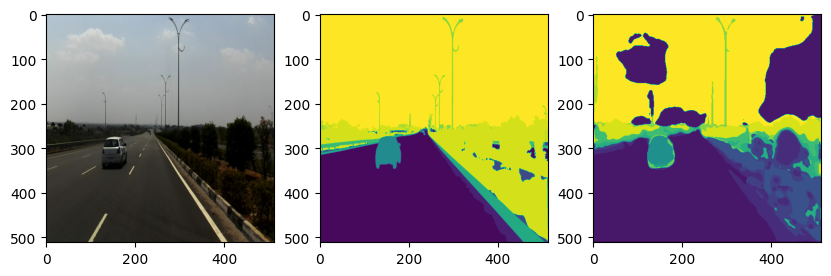

In [ ]:
for i in range(test_model.shape[0]):
  #original image
  image = cv2.imread(test_model['image'][i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)

  #original segmentation map
  image_mask = cv2.imread(test_model['mask'][i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (512,512), interpolation=cv2.INTER_AREA)
  image_mask = image_mask/10

  #predicted segmentation map
  predicted  = model.predict(image, verbose=1)
  predicted = tf.argmax(predicted, axis=-1)

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image[0,:,:])
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow(predicted[0,:,:])

  plt.show()

## 4. Training CANet

### 4.1 Build CANet

* Implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* Using the custom layers concept
* The whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>

In [25]:
tf.keras.backend.clear_session()

In [26]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel = 3,  filters= [4,4,8], stride = 1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        self.conv2D_1 = Conv2D(self.F1, 1, activation='relu', padding='same')
        self.conv2D_2 = Conv2D(self.F2, self.kernel, strides=(self.stride,self.stride), activation='relu', padding='same')
        self.conv2D_3 = Conv2D(self.F3, 1 , activation='relu', padding='same')
        self.conv2D_4 = Conv2D(self.F3, self.kernel, strides=(self.stride,self.stride), activation='relu', padding='same')

        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.bn4 = BatchNormalization(axis=3)

        self.activ = Activation("relu")
        self.add = Add()


    def call(self, X):

        conv_1 = self.conv2D_1(X)
        batch_norm_1 = self.bn1(conv_1)
        activ_layer_1 = self.activ(batch_norm_1)

        conv_2 = self.conv2D_2(activ_layer_1)
        batch_norm_2 = self.bn2(conv_2)
        activ_layer_2 = self.activ(batch_norm_2)

        conv_3 = self.conv2D_3(activ_layer_2)
        batch_norm_3 = self.bn3(conv_3)

        conv_4 = self.conv2D_4(X)
        batch_norm_4 = self.bn4(conv_4)
        activ_layer_4 = self.activ(batch_norm_4)

        conv_out = self.add([batch_norm_3,activ_layer_4])
        activ_layer = self.activ(conv_out)

        return activ_layer

In [27]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters

        self.conv2a = Conv2D(self.F1, (1, 1), activation='relu',padding='same')
        self.conv2b = Conv2D(self.F2, (3,3), activation='relu', padding='same')
        self.conv2c = Conv2D(self.F3, (1,1), activation='relu', padding='same')

        self.bn2a = BatchNormalization(axis=3)
        self.bn2b = BatchNormalization(axis=3)
        self.bn2c = BatchNormalization(axis=3)

        self.activ_layer = Activation('relu')
        self.add = Add()

    def call(self, X):

        convId_1 = self.conv2a(X)
        bn_1 = self.bn2a(convId_1)
        activ_1 = self.activ_layer(bn_1)

        convId_3 = self.conv2b(activ_1)
        bc_2 = self.bn2b(convId_3)
        activ_2 = self.activ_layer(bc_2)

        convId_3 = self.conv2c(activ_2)
        bc_3 = self.bn2c(convId_3)

        addition = self.add([bc_3,X])
        activ_3 = self.activ_layer(addition)

        return activ_3

* Chained Context Aggregation Module (CAM)
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>
    
* <strong>The Context flow</strong>

In [28]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.gvPool = GlobalAveragePooling2D()
        self.reshape = Reshape((1,1,64))
        self.bn1 = BatchNormalization()
        self.activ = Activation("relu")
        self.conv2D = Conv2D(32, 1 , activation='relu', padding='same')
        self.upsample = UpSampling2D(size=(64, 64), interpolation='bilinear')


    def call(self, X):
        # implement the global flow operatiom
        global_avg_pool = self.gvPool(X)
        # print(X.shape, global_avg_pool.shape)
        batch_norm = self.bn1(global_avg_pool)
        activ_layer = self.activ(batch_norm)
        reshape = self.reshape(activ_layer)
        conv_layer = self.conv2D(reshape)
        up_sample_layer = self.upsample(conv_layer)

        return up_sample_layer

In [29]:
class context_flow(tf.keras.layers.Layer):
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.concat = Concatenate()
        self.avgPool = AveragePooling2D(pool_size=(2, 2))
        self.conv2D_1 = Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')
        self.conv2D_2 = Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')
        self.conv2D_3 = Conv2D(32, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")
        self.conv2D_4 = Conv2D(32, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")
        self.activ_1 = Activation("relu")
        self.activ_2 = Activation("sigmoid")
        self.mul = Multiply()
        self.add = Add()
        self.upsample = UpSampling2D(size=(2,2), interpolation='bilinear')


    def call(self, X):
        # here X will a list of two elements
        INP, FLOW = X[0], X[1]
        # implement the context flow as mentioned in the above cell

        # Context Fusion Module
        concat_layer = self.concat([INP, FLOW])
        avg_pool = self.avgPool(concat_layer)
        conv_layer_1 = self.conv2D_1(avg_pool)
        out_fusion = self.conv2D_2(conv_layer_1)

        # Context Refinement Module
        conv_1 = self.conv2D_3(out_fusion)
        active_relu = self.activ_1(conv_1)
        conv_2 = self.conv2D_4(active_relu)
        active_sigm = self.activ_2(conv_2)

        multi = self.mul([out_fusion,active_sigm])
        addi = self.add([out_fusion,multi])
        upsample = self.upsample(addi)

        return upsample

In [30]:
# Feature selection module
class fsm(tf.keras.layers.Layer):
    def __init__(self, name="feature_selection"):

        super().__init__(name=name)
        self.conv2D_1 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')

        self.globalPool = GlobalMaxPool2D()
        self.reshape = Reshape([1,1,32])
        self.conv2D_2 = Conv2D(32, kernel_size=(1,1), activation='relu', padding='same')
        self.bn1 = BatchNormalization(axis=3)
        self.activ = Activation("sigmoid")
        self.mul = Multiply()
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')

    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv_layer = self.conv2D_1(X)

        global_pool = self.globalPool(conv_layer)

        out_reshape = self.reshape(global_pool)

        conv_layer_1 = self.conv2D_2(out_reshape)

        batch_norm = self.bn1(conv_layer_1)

        activ_layer = self.activ(batch_norm)


        multi = self.mul([conv_layer,activ_layer])

        FSM_Conv_T = self.upsample(multi)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
  
  <img src="https://i.imgur.com/QNB8RmV.png" width="300">

In [31]:
# Adapted Global Convolutional Network
class agcn(tf.keras.layers.Layer):
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv2D_1 = Conv2D(32, (7,1), strides=(1,1) , activation='relu', padding='same')
        self.conv2D_2 = Conv2D(32, (1,7), strides=(1,1) , activation='relu', padding='same')
        self.conv2D_3 = Conv2D(32, (1,7), strides=(1,1) , activation='relu', padding='same')
        self.conv2D_4 = Conv2D(32, (7,1), strides=(1,1) , activation='relu', padding='same')
        self.conv2D_5 = Conv2D(32, 3, activation='relu', padding='same')
        self.add = Add()


    def call(self, X):
        # please implement the above mentioned architecture
        # Left
        conv_left_1 = self.conv2D_1(X)
        conv_left_2 = self.conv2D_2(conv_left_1)

        # Right
        conv_right_1 = self.conv2D_3(X)
        conv_right_2 = self.conv2D_4(conv_right_1)

        add_acn_1 = self.add([conv_left_2,conv_right_2])
        conv_layer =  self.conv2D_5(add_acn_1)
        add_acn_2 = self.add([conv_layer,add_acn_1])

        return add_acn_2


In [32]:
# Bulding model using custom layers

# Input Layer

X_input = Input(shape=(512,512,3))

X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)


# Conv_bloc_1
conv_input_1 = convolutional_block(filters=[4,4,8], stride=2, name="conv_block_1")(X)
idenity_layer_1 = identity_block(name="id_block_1")(conv_input_1)

# Conv_bloc_2
conv_input_2 = convolutional_block(filters=[8,8,16], stride=2, name="conv_block_2")(idenity_layer_1)
idenity_layer_21 = identity_block(filters=[8,8,16], name="id_block_21")(conv_input_2)
idenity_layer_22 = identity_block(filters=[8,8,16], name="id_block_22")(idenity_layer_21)

# Conv_bloc_3
conv_input_3 = convolutional_block(filters=[16,16,32], stride=1,name="conv_block_3")(idenity_layer_22)
idenity_layer_31 = identity_block(filters=[16,16,32], name="id_block_31")(conv_input_3)
idenity_layer_32 = identity_block(filters=[16,16,32], name="id_block_32")(idenity_layer_31)
idenity_layer_33 = identity_block(filters=[16,16,32], name="id_block_33")(idenity_layer_32)

# Conv_bloc_4
conv_input_4 = convolutional_block(filters=[32,32,64], name="conv_block_4")(idenity_layer_33)
idenity_layer_41 = identity_block(filters=[32,32,64], name="id_block_41")(conv_input_4)
idenity_layer_42 = identity_block(filters=[32,32,64], name="id_block_42")(idenity_layer_41)
idenity_layer_43 = identity_block(filters=[32,32,64], name="id_block_43")(idenity_layer_42)
idenity_layer_44 = identity_block(filters=[32,32,64], name="id_block_44")(idenity_layer_43)

# global_flow
global_flow_layer = global_flow()(idenity_layer_44)

# context_flow
context_flow_1 = context_flow(name="context_flow_1")([idenity_layer_44, global_flow_layer])
context_flow_2 = context_flow(name="context_flow_2")([idenity_layer_44, context_flow_1])
context_flow_3 = context_flow(name="context_flow_3")([idenity_layer_44, context_flow_2])

# add
add_cf = Add()([global_flow_layer,context_flow_1, context_flow_2, context_flow_3])

# Feature selection module (FSM)
fsm_layer = fsm()(add_cf)

# Adapted Global Convolutional Network (AGCN)
agcn_layer = agcn()(conv_input_1)

#concatinating FSM output and AGCN output
concat_layer = Concatenate()([agcn_layer,fsm_layer])

# conv layer
conv_out = Conv2D(21, 3, activation = 'relu', padding = 'same')(concat_layer)

# Up sampling
upsample_out = UpSampling2D(size=(4, 4), interpolation='bilinear')(conv_out)

# output layer
final_out = Activation('softmax')(upsample_out)


In [33]:
print(X_input.shape, final_out.shape)

(None, 512, 512, 3) (None, 512, 512, 21)


In [34]:
model = Model(inputs = [X_input], outputs = [final_out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 512, 512, 64)         256       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['bn_conv1[0][0]']        

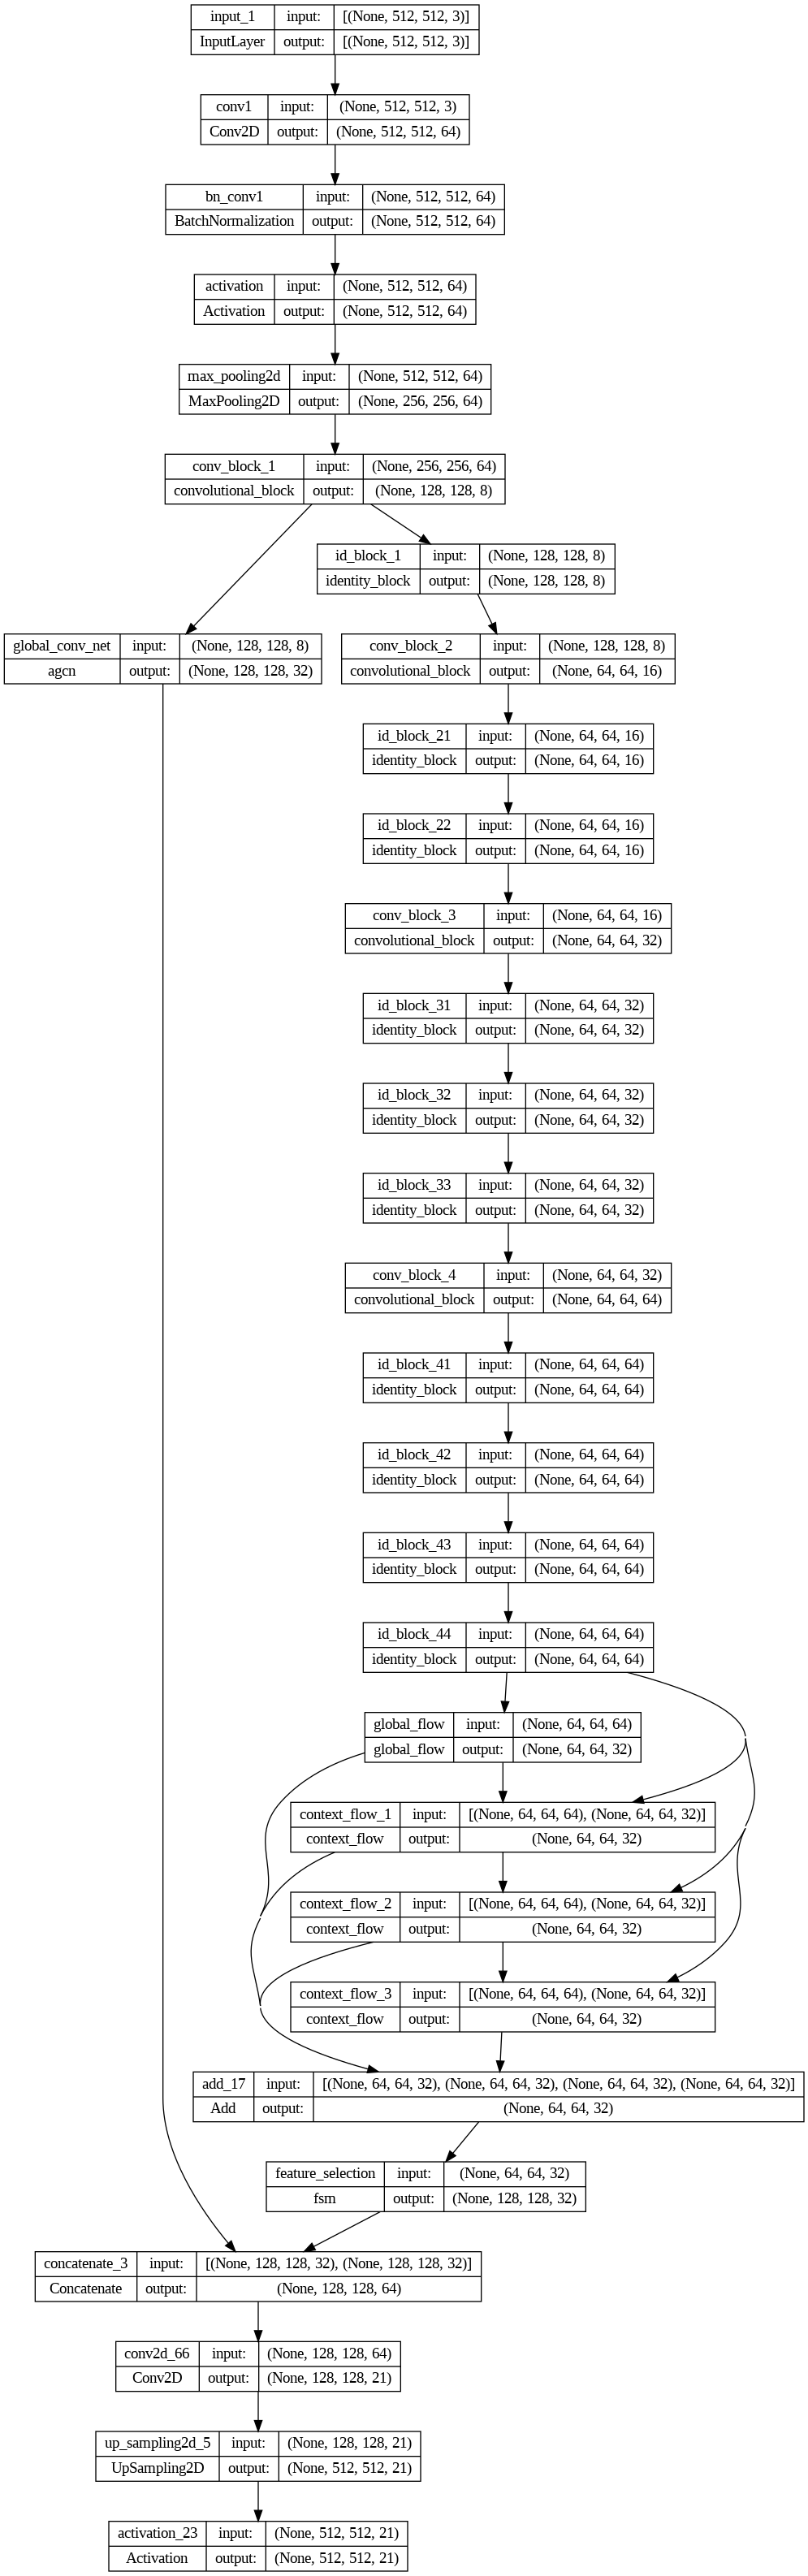

In [35]:
tf.keras.utils.plot_model(
    model, to_file='model_canet.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [37]:
optim = RMSprop(0.001)

focal_loss = sm.losses.cce_dice_loss

model.compile(optimizer = optim, loss= focal_loss, metrics=[iou_score])

In [38]:
callbacks = [ModelCheckpoint('best_weight_canet.h5', save_weights_only=True,
                                                save_best_only=True, mode='max', monitor='val_iou_score')
]

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,
                    validation_data=test_dataloader, callbacks=callbacks )

Epoch 1/20
425/425 [==============================] - 574s 1s/step - loss: 2.6508 - iou_score: 0.0879 - val_loss: 2.5917 - val_iou_score: 0.1016
Epoch 2/20
425/425 [==============================] - 568s 1s/step - loss: 1.9790 - iou_score: 0.1179 - val_loss: 1.9884 - val_iou_score: 0.1248
Epoch 3/20
425/425 [==============================] - 559s 1s/step - loss: 1.8740 - iou_score: 0.1281 - val_loss: 1.9670 - val_iou_score: 0.1272
Epoch 4/20
425/425 [==============================] - 554s 1s/step - loss: 1.6613 - iou_score: 0.2894 - val_loss: 1.7850 - val_iou_score: 0.3506
Epoch 5/20
425/425 [==============================] - 559s 1s/step - loss: 1.5434 - iou_score: 0.3610 - val_loss: 2.2378 - val_iou_score: 0.3242
Epoch 6/20
425/425 [==============================] - 557s 1s/step - loss: 1.4908 - iou_score: 0.3674 - val_loss: 1.5342 - val_iou_score: 0.3707
Epoch 7/20
425/425 [==============================] - 557s 1s/step - loss: 1.4582 - iou_score: 0.3727 - val_loss: 1.6568 - val_iou

<pre>
Observation:
<li>IOU score for Train data and Validation Data after 20th epoch are 0.4123 and 0.4012.
</pre>

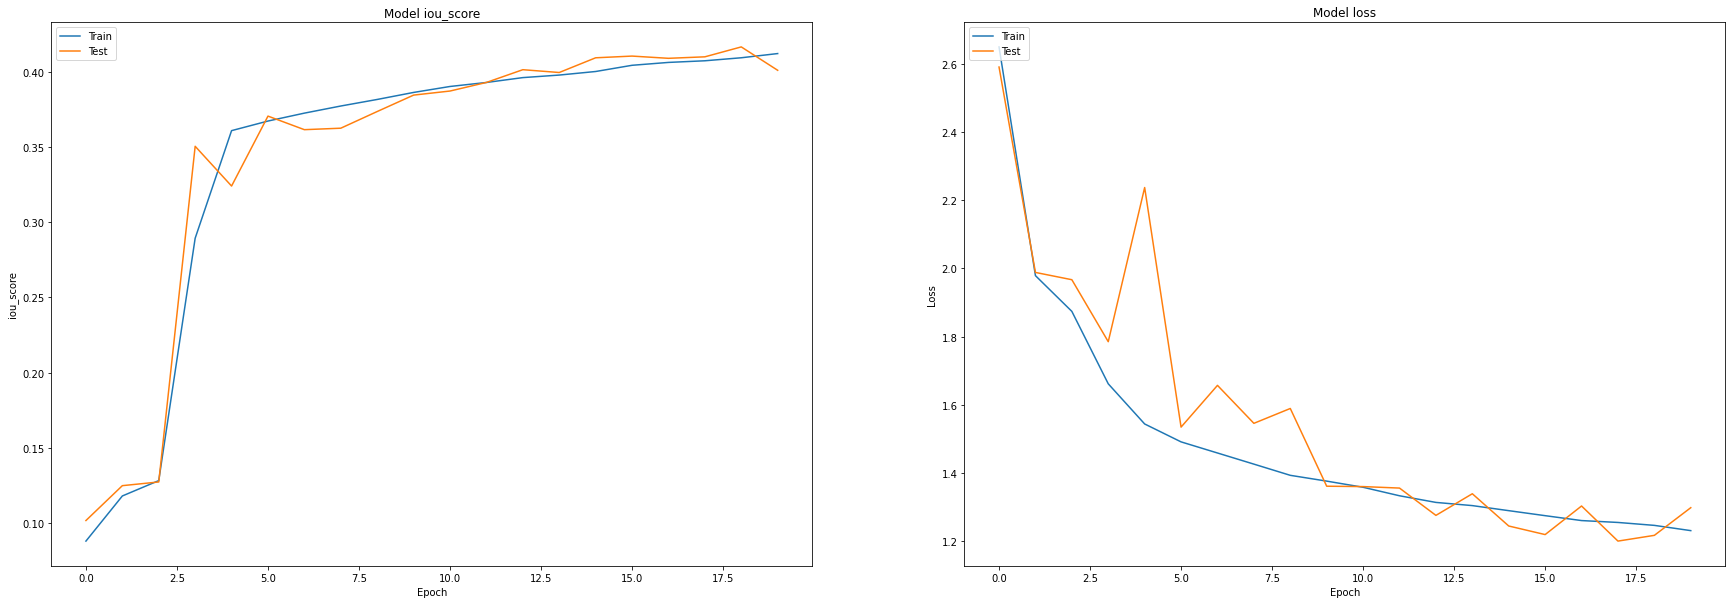

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
# Loading the best weights to model
model.load_weights("best_weight_canet.h5")

In [41]:
# Testing the model for 20 test images
test_model = X_test.sample(n = 20)
test_model = test_model.reset_index(drop=True)
test_model.head()

image  \
0     data/images/421/0000001_leftImg8bit.jpg   
1   data/images/247/frame5189_leftImg8bit.jpg   
2   data/images/359/frame2012_leftImg8bit.jpg   
3   data/images/356/frame3387_leftImg8bit.jpg   
4  data/images/371/frame14462_leftImg8bit.jpg   

                                            json  \
0     data/mask/421/0000001_gtFine_polygons.json   
1   data/mask/247/frame5189_gtFine_polygons.json   
2   data/mask/359/frame2012_gtFine_polygons.json   
3   data/mask/356/frame3387_gtFine_polygons.json   
4  data/mask/371/frame14462_gtFine_polygons.json   

                                             mask  
0     data/output/421/0000001_gtFine_polygons.png  
1   data/output/247/frame5189_gtFine_polygons.png  
2   data/output/359/frame2012_gtFine_polygons.png  
3   data/output/356/frame3387_gtFine_polygons.png  
4  data/output/371/frame14462_gtFine_polygons.png

1/1 [==============================] - 3s 3s/step


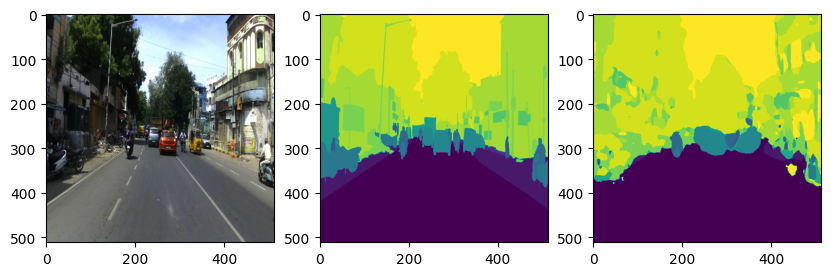

1/1 [==============================] - 0s 24ms/step


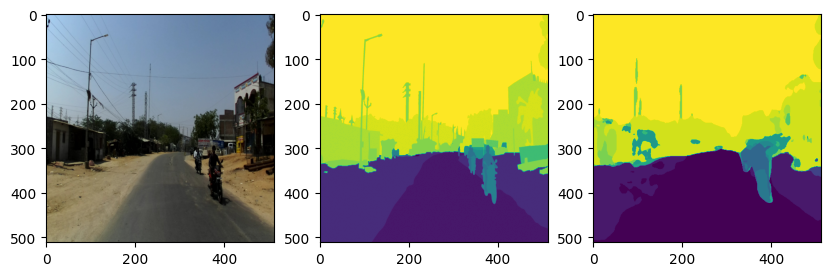

1/1 [==============================] - 0s 24ms/step


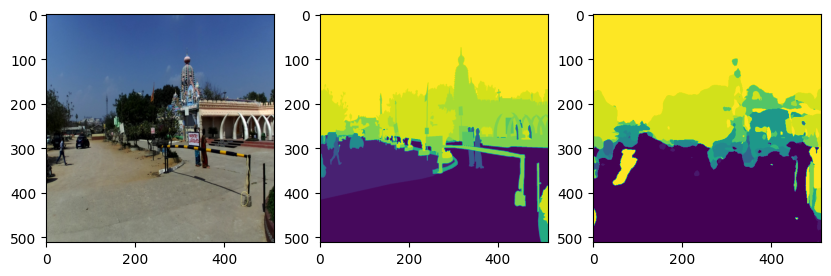

1/1 [==============================] - 0s 25ms/step


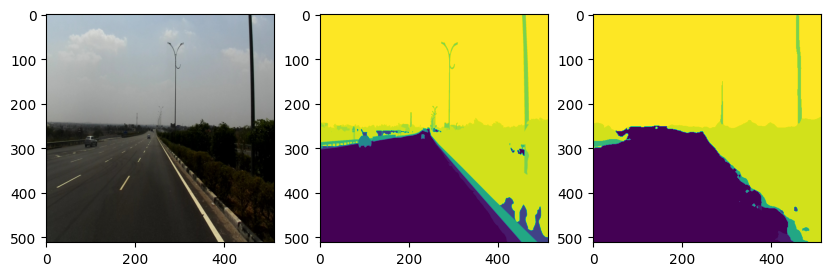

1/1 [==============================] - 0s 26ms/step


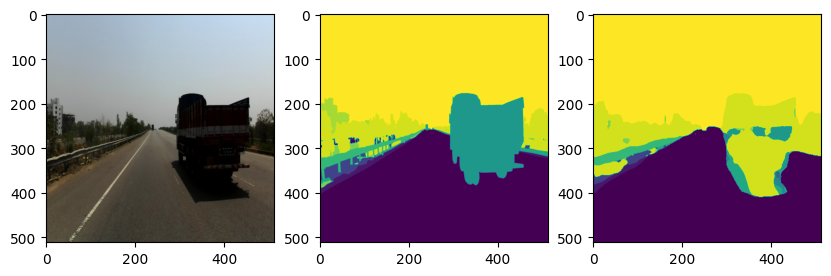

1/1 [==============================] - 0s 25ms/step


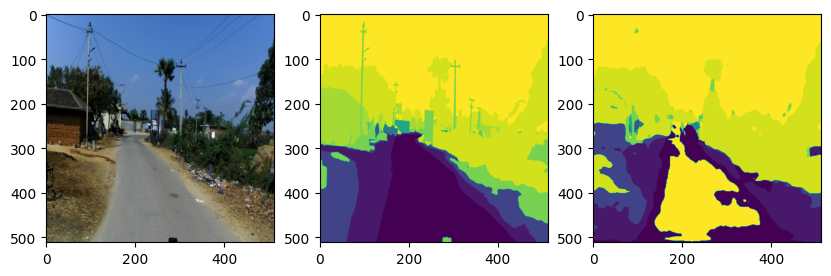

1/1 [==============================] - 0s 24ms/step


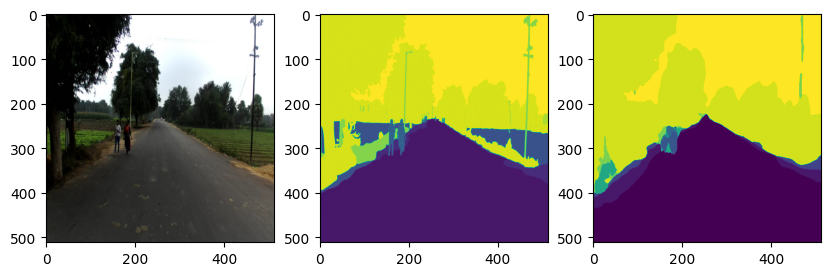

1/1 [==============================] - 0s 24ms/step


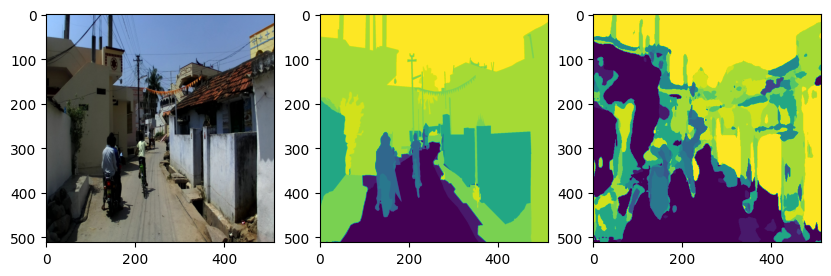

1/1 [==============================] - 0s 25ms/step


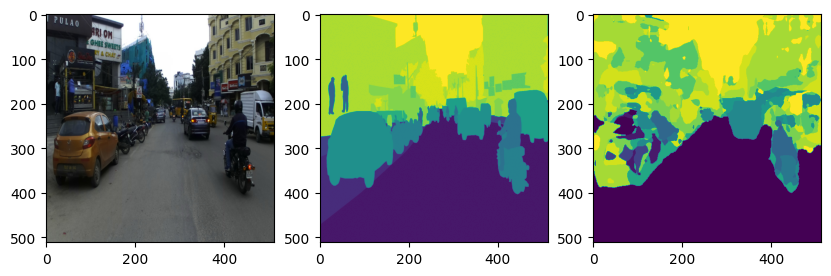

1/1 [==============================] - 0s 25ms/step


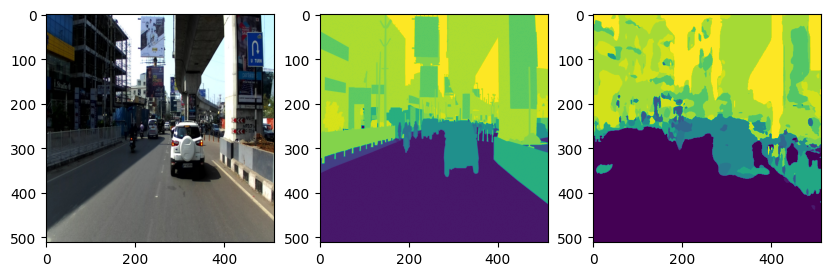

1/1 [==============================] - 0s 24ms/step


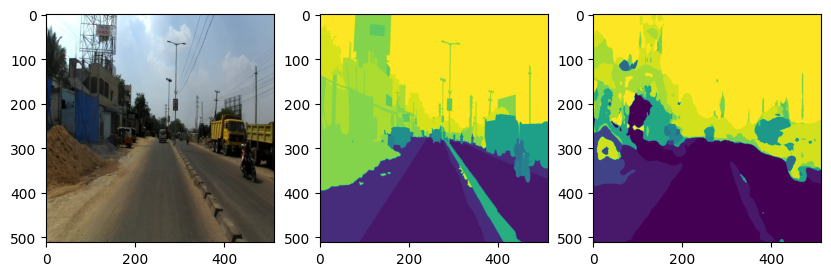

1/1 [==============================] - 0s 24ms/step


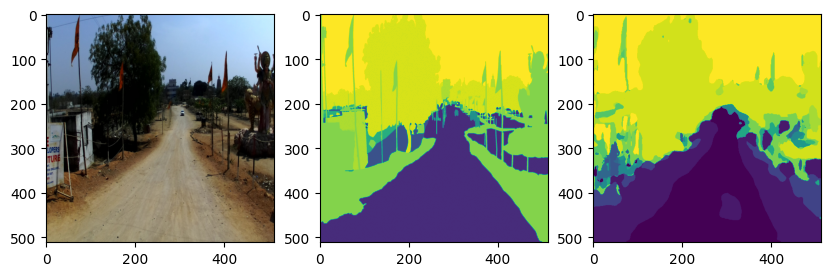

1/1 [==============================] - 0s 23ms/step


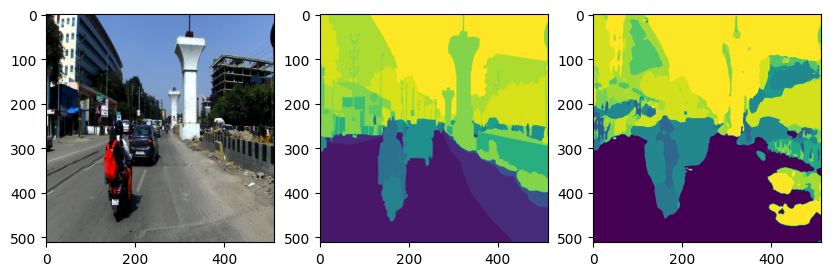

1/1 [==============================] - 0s 29ms/step


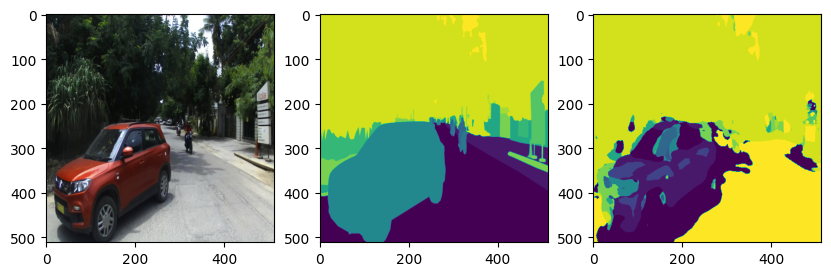

1/1 [==============================] - 0s 25ms/step


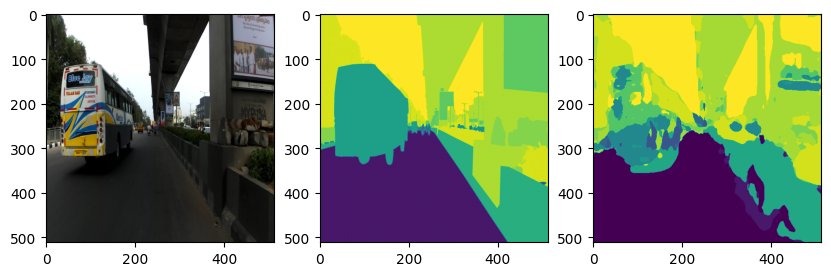

1/1 [==============================] - 0s 35ms/step


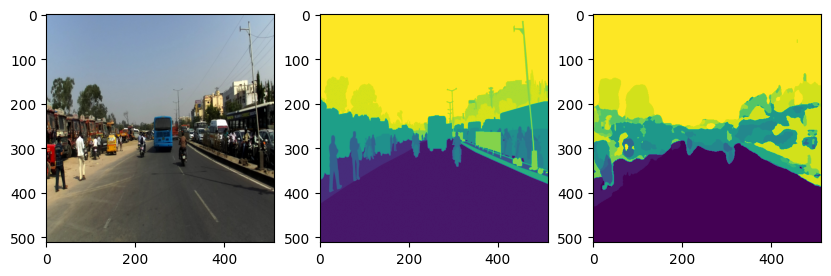

1/1 [==============================] - 0s 35ms/step


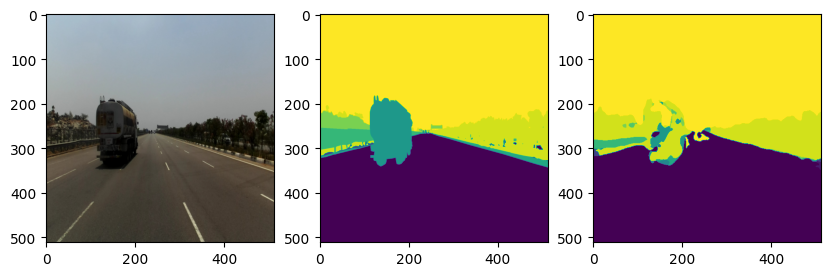

1/1 [==============================] - 0s 36ms/step


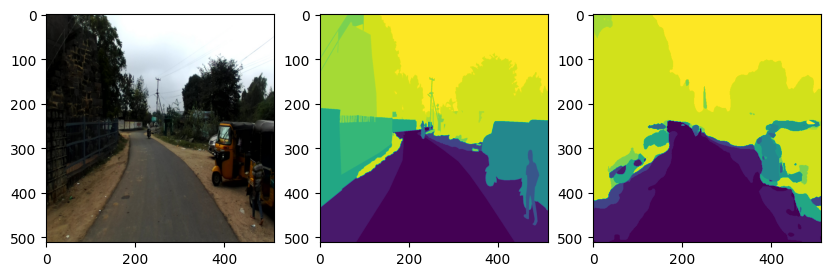

1/1 [==============================] - 0s 36ms/step


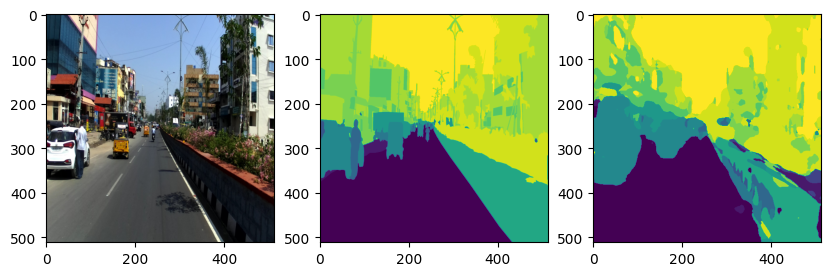

1/1 [==============================] - 0s 40ms/step


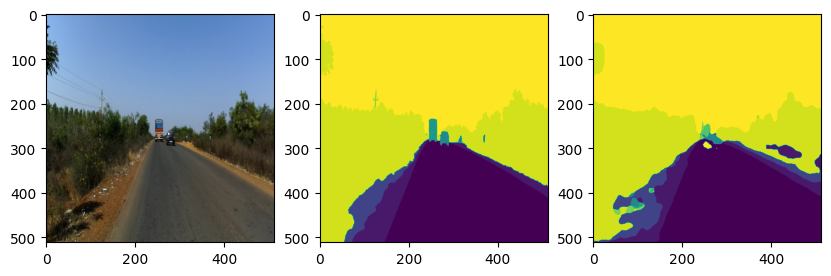

In [42]:
for i in range(test_model.shape[0]):
  # original image
  image = cv2.imread(test_model['image'][i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)

  # original segmentation map
  image_mask = cv2.imread(test_model['mask'][i], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (512,512), interpolation=cv2.INTER_AREA)
  image_mask = image_mask/10

  # predicted segmentation map
  predicted  = model.predict(image, verbose=1)
  predicted = tf.argmax(predicted, axis=-1)

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image[0,:,:])
  plt.subplot(132)
  plt.imshow(image_mask)
  plt.subplot(133)
  plt.imshow(predicted[0,:,:])

  plt.show()